# Machine Learning with PyTorch and Scikit-Learn


In [1]:
import sys
sys.path.insert(0, '..')

In [41]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [42]:
X = ((X / 255.) - .5) * 2

In [45]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=123, stratify=y_temp)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# optional to free up some memory by deleting non-used arrays:
# del X_temp, y_temp, X, y

# **Implementing a multi-layer perceptron**



---




In [47]:
import numpy as np

class NeuralNetMLPSingle:
    def __init__(self, n_hidden, l2, epochs, eta):
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta

    def forward(self, X):
        # Compute activations of hidden layer
        z_h = np.dot(X, self.weight_h) + self.bias_h
        a_h = self._sigmoid(z_h)

        # Compute activations of output layer
        z_out = np.dot(a_h, self.weight_out) + self.bias_out
        a_out = self._softmax(z_out)

        return a_h, a_out

    def backward(self, X, a_h, a_out, y):
        # Output layer gradients
        grad_out = a_out - self._onehot_encoding(y)

        # Hidden layer gradients
        grad_h = np.dot(grad_out, self.weight_out.T) * self._sigmoid_derivative(a_h)

        # Weight gradients
        d_loss__d_w_out = np.dot(a_h.T, grad_out)
        d_loss__d_b_out = np.sum(grad_out, axis=0)
        d_loss__d_w_h = np.dot(X.T, grad_h)
        d_loss__d_b_h = np.sum(grad_h, axis=0)

        # Add L2 regularization to weight gradients
        d_loss__d_w_out += self.l2 * self.weight_out
        d_loss__d_w_h += self.l2 * self.weight_h

        return d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h

    def fit(self, X, y):
        # Initialize weights and biases
        self.weight_h = np.random.uniform(-1, 1, size=(X.shape[1], self.n_hidden))
        self.bias_h = np.zeros(self.n_hidden)
        self.weight_out = np.random.uniform(-1, 1, size=(self.n_hidden, np.unique(y).shape[0]))
        self.bias_out = np.zeros(np.unique(y).shape[0])

        # Convert class labels to integers if necessary
        if y.dtype == object:
            y = self._label_encoder(y)

        # One-hot encode the target variable
        y_enc = self._onehot_encoding(y)

        # Iterate over epochs
        for _ in range(self.epochs):
            a_h, a_out = self.forward(X)
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = self.backward(X, a_h, a_out, y)

            # Update weights and biases
            self.weight_h -= self.eta * d_loss__d_w_h
            self.bias_h -= self.eta * d_loss__d_b_h
            self.weight_out -= self.eta * d_loss__d_w_out
            self.bias_out -= self.eta * d_loss__d_b_out

    def predict(self, X):
        a_h, a_out = self.forward(X)
        return np.argmax(a_out, axis=1)

    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _sigmoid_derivative(self, a):
        return a * (1 - a)

    def _onehot_encoding(self, y):
        return np.eye(np.unique(y).shape[0])[y]

    def _label_encoder(self, y):
        classes = np.unique(y)
        mapping = {label: idx for idx, label in enumerate(classes)}
        return np.array([mapping[label] for label in y])


def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_losses = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for epoch in range(num_epochs):
        model.fit(X_train, y_train)

        # Compute training loss and accuracy
        train_loss, train_acc = compute_mse_and_acc(model, X_train, y_train)
        epoch_losses.append(train_loss)
        epoch_train_acc.append(train_acc)

        # Compute validation accuracy
        _, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        epoch_valid_acc.append(valid_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f} | Valid Acc: {valid_acc:.2f}")

    return epoch_losses, epoch_train_acc, epoch_valid_acc


def compute_mse_and_acc(model, X, y):
    y_pred = model.predict(X)
    mse = mse_loss(y, y_pred)
    acc = accuracy(y, y_pred)
    return mse, acc


def mse_loss(targets, predicted_labels):
    return np.mean((targets - predicted_labels) ** 2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


In [ ]:
# Train the model with single hidden layer
num_epochs = 50
learning_rate = 0.1

model_single = NeuralNetMLPSingle(n_hidden=100, l2=0.1, epochs=num_epochs, eta=learning_rate)
losses_single, train_acc_single, valid_acc_single = train(model_single, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate)

# Evaluate on the test set
test_mse_single, test_acc_single = compute_mse_and_acc(model_single, X_test, y_test)

print(f"Single Hidden Layer Model:")
print(f"Test Accuracy: {test_acc_single*100:.2f}%")
print(f'Initial valid MSE: {test_mse_single:.1f}')


Epoch 1/50 | Train Loss: 8.65 | Train Acc: 0.09 | Valid Acc: 0.09
Epoch 2/50 | Train Loss: 10.75 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 3/50 | Train Loss: 20.27 | Train Acc: 0.11 | Valid Acc: 0.11
Epoch 4/50 | Train Loss: 8.65 | Train Acc: 0.09 | Valid Acc: 0.09
Epoch 5/50 | Train Loss: 8.56 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 6/50 | Train Loss: 8.65 | Train Acc: 0.09 | Valid Acc: 0.09
Epoch 7/50 | Train Loss: 29.03 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 8/50 | Train Loss: 29.03 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 9/50 | Train Loss: 8.56 | Train Acc: 0.10 | Valid Acc: 0.10
Epoch 10/50 | Train Loss: 8.65 | Train Acc: 0.09 | Valid Acc: 0.09
Epoch 11/50 | Train Loss: 20.27 | Train Acc: 0.11 | Valid Acc: 0.11


# **Implementing a multi-layer perceptron and multi-hiden-layer ANN**




In [11]:
import numpy as np

In [12]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden layers
        rng = np.random.RandomState(random_seed)

        self.weight_h1 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        self.weight_h2 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer 1
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer 2
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):
        # Output layer weights gradients
        y_onehot = int_to_onehot(y, self.num_classes)
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        d_z_out__dw_out = a_h2
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        # Hidden layer 2 weights gradients
        d_z_out__a_h2 = self.weight_out
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)
        d_z_h2__dw_h2 = a_h1
        d_loss__dw_h2 = np.dot((d_loss__a_h2 * d_a_h2__d_z_h2).T, d_z_h2__dw_h2)
        d_loss__db_h2 = np.sum(d_loss__a_h2 * d_a_h2__d_z_h2, axis=0)

        # Hidden layer 1 weights gradients
        d_z_h2__a_h1 = self.weight_h2
        d_loss__a_h1 = np.dot(d_loss__a_h2 * d_a_h2__d_z_h2, d_z_h2__a_h1)
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
        d_z_h1__dw_h1 = x
        d_loss__dw_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h1__dw_h1)
        d_loss__db_h1 = np.sum(d_loss__a_h1 * d_a_h1__d_z_h1, axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__dw_h2, d_loss__db_h2,
                d_loss__dw_h1, d_loss__db_h1)
        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [30]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, train_mse


In [27]:

# Define the model with two hidden layers
model = NeuralNetMLP(num_features=28*28, num_hidden1=50, num_hidden2=50, num_classes=10)


In [33]:
np.random.seed(123) # for the training set shuffling

# Train the model
epoch_loss, epoch_train_acc, epoch_valid_acc, train_mse = train(model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1)
print(f"Two Hidden Layer Model:")
print(f"Test Accuracy: {np.mean(epoch_valid_acc):.2f}%")
print(f'Initial valid MSE: {train_mse:.1f}')



Epoch: 001/050 | Train MSE: 0.00 | Train Acc: 98.52% | Valid Acc: 96.24%
Epoch: 002/050 | Train MSE: 0.00 | Train Acc: 98.50% | Valid Acc: 96.24%
Epoch: 003/050 | Train MSE: 0.00 | Train Acc: 98.55% | Valid Acc: 96.42%
Epoch: 004/050 | Train MSE: 0.00 | Train Acc: 98.55% | Valid Acc: 96.46%
Epoch: 005/050 | Train MSE: 0.00 | Train Acc: 98.56% | Valid Acc: 96.38%
Epoch: 006/050 | Train MSE: 0.00 | Train Acc: 98.53% | Valid Acc: 96.24%
Epoch: 007/050 | Train MSE: 0.00 | Train Acc: 98.57% | Valid Acc: 96.24%
Epoch: 008/050 | Train MSE: 0.00 | Train Acc: 98.58% | Valid Acc: 96.22%
Epoch: 009/050 | Train MSE: 0.00 | Train Acc: 98.61% | Valid Acc: 96.30%
Epoch: 010/050 | Train MSE: 0.00 | Train Acc: 98.62% | Valid Acc: 96.30%
Epoch: 011/050 | Train MSE: 0.00 | Train Acc: 98.61% | Valid Acc: 96.38%
Epoch: 012/050 | Train MSE: 0.00 | Train Acc: 98.61% | Valid Acc: 96.40%
Epoch: 013/050 | Train MSE: 0.00 | Train Acc: 98.62% | Valid Acc: 96.38%
Epoch: 014/050 | Train MSE: 0.00 | Train Acc: 98.64

# **fully connected ANN implemented using Keras**

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Convert target labels to categorical format
y_train_categorical = to_categorical(y_train)
y_valid_categorical = to_categorical(y_valid)

# Define the model architecture
model_keras = Sequential()
model_keras.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
model_keras.add(Dense(units=10, activation='softmax'))

# Compile the model
model_keras.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model_keras.fit(X_train, y_train_categorical, epochs=num_epochs, batch_size=minibatch_size, validation_data=(X_valid, y_valid_categorical))

# Evaluate on the test set
y_test_categorical = to_categorical(y_test)
test_loss_keras, test_acc_keras = model_keras.evaluate(X_test, y_test_categorical, verbose=0)

print(f"Keras Fully Connected ANN:")
print(f"Test Accuracy: {test_acc_keras*100:.2f}%")


Epoch 1/50
550/550 [==============================] - 4s 5ms/step - loss: 4.0412 - accuracy: 0.8151 - val_loss: 0.8586 - val_accuracy: 0.8486
Epoch 2/50
550/550 [==============================] - 3s 5ms/step - loss: 0.5702 - accuracy: 0.8788 - val_loss: 0.5629 - val_accuracy: 0.9024
Epoch 3/50
550/550 [==============================] - 3s 5ms/step - loss: 0.3691 - accuracy: 0.9138 - val_loss: 0.4670 - val_accuracy: 0.9152
Epoch 4/50
550/550 [==============================] - 4s 6ms/step - loss: 0.2789 - accuracy: 0.9301 - val_loss: 0.4027 - val_accuracy: 0.9268
Epoch 5/50
550/550 [==============================] - 2s 4ms/step - loss: 0.2251 - accuracy: 0.9409 - val_loss: 0.3737 - val_accuracy: 0.9294
Epoch 6/50
550/550 [==============================] - 2s 4ms/step - loss: 0.2042 - accuracy: 0.9450 - val_loss: 0.3443 - val_accuracy: 0.9338
Epoch 7/50
550/550 [==============================] - 2s 4ms/step - loss: 0.1792 - accuracy: 0.9504 - val_loss: 0.3267 - val_accuracy: 0.9410
Epoch 

## Coding the neural network training loop




Defining data loaders:

In [15]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [17]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


a_h1, a_h2, a_out = model.forward(X_valid)
mse = mse_loss(y_valid, a_out)

predicted_labels = np.argmax(a_out, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 9.0%


<ipython-input-12-e6b9f59fa33e>:6: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-z))


In [18]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        a_h1, a_h2, a_out = nnet.forward(features)
        predicted_labels = np.argmax(a_out, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - a_out)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [19]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.0%


<ipython-input-12-e6b9f59fa33e>:6: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-z))


## Evaluating the neural network performance

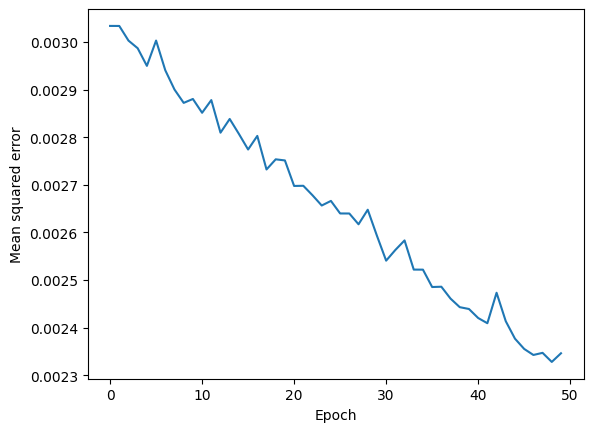

In [34]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

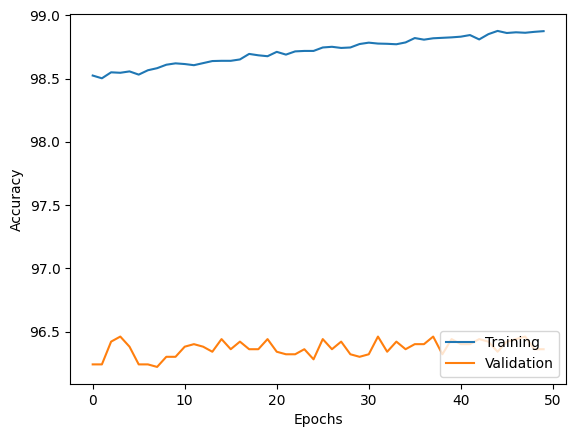

In [35]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [36]:
# Evaluate on test data
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
test_acc *= 100

print(f'Test MSE: {test_mse:.2f}')
print(f'Test Accuracy: {test_acc:.2f}%')

Test MSE: 0.01
Test Accuracy: 96.65%
